# Pandora metrics

Purpose of this notebook is to introduce the definition of some important metrics, and produce the corresponding reference peformance results achieved by Pandora [Eur. Phys. J. C 78, 82 (2018), https://arxiv.org/abs/1708.03135], the reconstruction toolkit used in many MicroBooNE publications.

Get libraries, utils, and data

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
from standard_labels import *
from file_utils import *

In [10]:
f = h5py.File("NeutrinoML_Open_NoWire_bnb-test.h5", "r")
#f = h5py.File("NeutrinoML_Open_NoWire_nue-test.h5", "r")

Convert hit, pandoraHit, and edep tables into data frames. The pandoraHit table contains information about how pandora clustered those hits. The edep table contains the truth information about the hits. Merge the data frames based on the hit_id and the edep with largest contribution to the hit in terms for energy fraction.

In [11]:
hits = Table2DataFrame(f["hit_table"])

pandhits = Table2DataFrame(f["pandoraHit_table"])
hits = hits.merge(pandhits, on=["run","sub","evt","hit_id"])

edeps = Table2DataFrame(f["edep_table"])
edeps = edeps.sort_values(by=['energy_fraction'], ascending=False, kind='mergesort').drop_duplicates(["run","sub","evt","hit_id"])
hits = hits.merge(edeps, on=["run","sub","evt","hit_id"], how="left")
hits['g4_id'] = hits['g4_id'].fillna(-1)
hits = hits.fillna(0)

hits


,run,sub,evt,hit_id,integral,local_plane,local_time,local_wire,rms,tpc,pfp_id,slice_id,energy,energy_fraction,g4_id
0,7419,0,1,0,31.001060,0,368.940857,0,2.765357,0,-1,5,0.0,0.0,-1.0
1,7419,0,1,1,29.861094,0,1454.587402,0,2.674901,0,-1,5,0.0,0.0,-1.0
2,7419,0,1,2,86.232323,0,2416.763184,0,5.333233,0,-1,5,0.0,0.0,-1.0
3,7419,0,1,3,23.252098,0,4613.027832,0,3.065675,0,-1,5,0.0,0.0,-1.0
4,7419,0,1,4,46.391190,0,5387.874023,18,3.545477,0,-1,3,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12456527,7633,266,13321,12831,127.240005,2,4426.600098,3418,2.935537,0,-1,10,0.0,0.0,-1.0
12456528,7633,266,13321,12832,34.886086,2,1313.287598,3422,3.231390,0,-1,12,0.0,0.0,-1.0
12456529,7633,266,13321,12833,34.118492,2,4390.883301,3427,3.108485,0,-1,10,0.0,0.0,-1.0
12456530,7633,266,13321,12834,39.177521,2,343.569244,3441,3.387861,0,-1,20,0.0,0.0,-1.0


Pandora separates hits into "slices", where each slice is meant to collect hits from a different interaction (whether from neutrino or cosmic rays). Identifying the neutrino interaction slice is a fundamental step for the reconstruction of the neutrino interaction.

We first extract the hit information counting the hits in each slice for each event.

In [12]:
slicehits = hits.groupby(["run","sub","evt","slice_id"]).size().reset_index().rename(columns={0:'tothits'})
slnuhits = hits[hits['g4_id']>=0].groupby(["run","sub","evt","slice_id"]).size().reset_index().rename(columns={0:'nuhits'})

slicehits = slicehits.merge(slnuhits, on=["run","sub","evt","slice_id"], how='left')
slicehits['nuhits'] = slicehits['nuhits'].fillna(0)
slicehits

,run,sub,evt,slice_id,tothits,nuhits
0,7419,0,1,-1,1,0.0
1,7419,0,1,0,1495,8.0
2,7419,0,1,1,1499,3.0
3,7419,0,1,2,1221,0.0
4,7419,0,1,3,1198,0.0
...,...,...,...,...,...,...
17539,7633,266,13321,17,7,0.0
17540,7633,266,13321,18,7,0.0
17541,7633,266,13321,19,7,0.0
17542,7633,266,13321,20,6,0.0


We can now plot the fraction of neutrino hits (purity) in all pandora slices, including both those identified as neutrino and those identified as cosmics. Ideally we would like to have two populations, one peaking at zero (for cosmic slices) and one peaking at one (for neutrino slices).

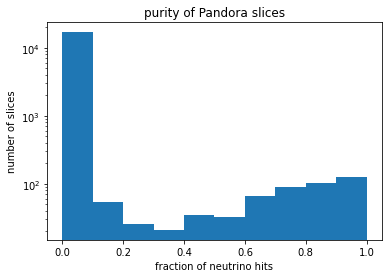

In [13]:
plt.hist(slicehits['nuhits']/slicehits['tothits'],bins=10,range=(0,1))
plt.yscale('log')
plt.xlabel('fraction of neutrino hits')
plt.ylabel('number of slices')
plt.title('purity of Pandora slices')
plt.show()

Now, in order to make a more detailed analysis of the slice properties, we need to use the "pandoraPrimary" table, which gathers information from the slice identification and high-level neutrino reconstruction. Primary here refers to the particle entering the detector and interacting with the argon. Products of this interaction would be considered "secondaries" and their info is in the "pandoraPfp_table".

In [14]:
primary = Table2DataFrame(f["pandoraPrimary_table"])
primary

,run,sub,evt,vtx_0,vtx_1,vtx_2,vtx_wire_pos_0,vtx_wire_pos_1,vtx_wire_pos_2,flashmatch_score,nu_score,pdg,slice_id,vtx_wire_time
0,7419,0,1,148.910645,112.791679,596.446350,1007,1652,1987,36.223362,-999.000000,13,0,3512.572021
1,7419,0,1,15.657176,114.753769,359.529266,606,1263,1198,126.976807,-999.000000,13,1,1085.212769
2,7419,0,1,248.027817,111.200584,142.987137,255,892,476,49.429428,-999.000000,13,2,5318.101074
3,7419,0,1,251.751404,116.713654,10.067689,18,686,33,29.871815,-999.000000,13,3,5385.930176
4,7419,0,1,130.091476,113.328796,438.976685,743,1391,1462,13.516474,-999.000000,13,4,3169.760010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24856,7633,266,13321,116.354889,-93.944382,1007.700012,2289,1741,3358,67.637939,0.030077,13,12,2919.532959
24857,7633,266,13321,-25.039635,-44.646664,1032.623047,2188,1925,3441,9999.000000,-999.000000,13,20,343.875366
24858,7633,266,13321,-8.037396,69.183601,953.634399,1728,2122,3178,66.650589,-999.000000,13,21,653.589966
24859,7633,266,13321,-999.000000,-999.000000,-999.000000,0,0,0,9999.000000,0.030077,11,12,-17397.890625


Since slices identified as cosmics may contain more than one identified cosmic interaction, if we want to study slice properties we need to identify these cases and drop the corresponding duplicate entries. By merging with the slicehits dataframe we now have access to both the slice hits and slice indentification infomation.

In [15]:
slices = primary.drop_duplicates(["run","sub","evt","slice_id"])
slices = slices.merge(slicehits, on=["run","sub","evt","slice_id"], how='left')
slices

,run,sub,evt,vtx_0,vtx_1,vtx_2,vtx_wire_pos_0,vtx_wire_pos_1,vtx_wire_pos_2,flashmatch_score,nu_score,pdg,slice_id,vtx_wire_time,tothits,nuhits
0,7419,0,1,148.910645,112.791679,596.446350,1007,1652,1987,36.223362,-999.000000,13,0,3512.572021,1495,8.0
1,7419,0,1,15.657176,114.753769,359.529266,606,1263,1198,126.976807,-999.000000,13,1,1085.212769,1499,3.0
2,7419,0,1,248.027817,111.200584,142.987137,255,892,476,49.429428,-999.000000,13,2,5318.101074,1221,0.0
3,7419,0,1,251.751404,116.713654,10.067689,18,686,33,29.871815,-999.000000,13,3,5385.930176,1198,0.0
4,7419,0,1,130.091476,113.328796,438.976685,743,1391,1462,13.516474,-999.000000,13,4,3169.760010,889,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17480,7633,266,13321,274.047974,-96.239708,843.779541,2022,1461,2812,9999.000000,-999.000000,13,18,5792.086914,7,0.0
17481,7633,266,13321,-11.439162,88.468765,931.754944,1636,2141,3105,9999.000000,-999.000000,13,19,591.622986,7,0.0
17482,7633,266,13321,-25.039635,-44.646664,1032.623047,2188,1925,3441,9999.000000,-999.000000,13,20,343.875366,6,0.0
17483,7633,266,13321,-8.037396,69.183601,953.634399,1728,2122,3178,66.650589,-999.000000,13,21,653.589966,6,0.0


We can now separate the two populations mentioned above, by selecting the slices identified as neutrino (pdg code 12 or 14, for nue and numu) from those identified as cosmics.

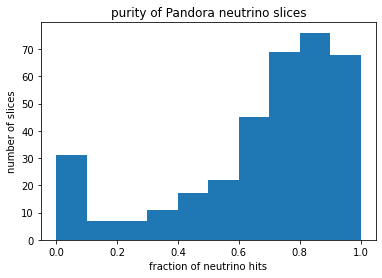

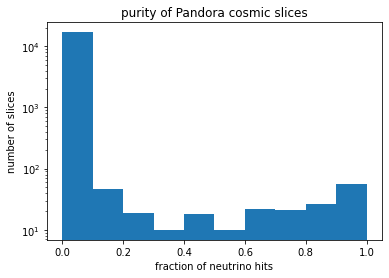

In [16]:
nuslices = slices[(slices['pdg']==12)|(slices['pdg']==14)]
plt.hist(nuslices['nuhits']/nuslices['tothits'],bins=10,range=(0,1))
plt.xlabel('fraction of neutrino hits')
plt.ylabel('number of slices')
plt.title('purity of Pandora neutrino slices')
plt.show()

cosmslices = slices[(slices['pdg']!=12)&(slices['pdg']!=14)]
plt.hist(cosmslices['nuhits']/cosmslices['tothits'],bins=10,range=(0,1))
plt.yscale('log')
plt.xlabel('fraction of neutrino hits')
plt.ylabel('number of slices')
plt.title('purity of Pandora cosmic slices')
plt.show()

In [17]:
#to do: add metrics for e.g. vertex resolution, muon length